In [20]:
from modules.linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
import pandas as pd

In [21]:
matplotlib inline

# Agrupamento (*Clustering*)

A maioria dos algoritmos deste livro é conhecida como aprendizado supervisionado, em que eles começam com um conjunto de dados rotulados e usam isso como base para fazer previsões sobre novos dados não rotulados. O agrupamento, no entanto, é um exemplo de aprendizado não supervisionado, no qual trabalhamos com dados completamente não rotulados (ou nos quais nossos dados têm rótulos, mas os ignoramos).

## A ideia

Sempre que você olha para alguma fonte de dados, é provável que os dados de alguma forma formem *clusters*. Um conjunto de dados mostrando onde os milionários vivem provavelmente tem clusters em lugares como Beverly Hills e Manhattan. Um conjunto de dados mostrando quantas horas as pessoas trabalham a cada semana provavelmente tem um cluster em torno de 40 (e se for retirado de um estado com leis que exigem benefícios especiais para pessoas que trabalhem pelo menos 20 horas por semana, provavelmente tem outro cluster em torno de 19). Um conjunto de dados demográficos de eleitores registrados provavelmente forma uma variedade de clusters (por exemplo, "mães do futebol", "aposentados entediados", "millennials desempregados") que os pesquisadores de opinião e os consultores políticos consideram relevantes.

Ao contrário de alguns dos problemas que analisamos, geralmente não há um agrupamento "correto". Um esquema de agrupamento alternativo pode agrupar alguns dos "millennials desempregados" com os "estudantes de graduação", outros com "moradores dos porões dos pais". Nenhum dos esquemas é necessariamente mais correto - em vez disso, cada um é mais otimizado em relação a sua própria métrica "o quão bons são os clusters?".

Além disso, os clusters não se rotulam. Você terá que fazer isso observando os dados subjacentes a cada um deles.

## O modelo

Para nós, cada entrada será um vetor no espaço d-dimensional (que, como de costume, vamos representar como uma lista de números). Nosso objetivo será identificar clusters de entradas similares e (às vezes) encontrar um valor representativo para cada cluster.

Por exemplo, cada entrada poderia ser (um vetor numérico que de alguma forma representa) o título de uma postagem de blog, e nesse caso a meta poderia ser encontrar grupos de postagens semelhantes, talvez para entender o que nossos usuários estão blogando. Ou imagine que temos uma imagem contendo milhares de cores (vermelhas, verdes, azuis) e que precisamos imprimir uma versão de 10 cores. O armazenamento em cluster pode nos ajudar a escolher 10 cores que minimizem o "erro de cor" total.

Um dos métodos de cluster mais simples é o *k-means*, em que o número de clusters *k* é escolhido antecipadamente, após o qual o objetivo é dividir as entradas em conjuntos $S_1, \cdots, S_k$ de uma maneira que minimize a soma total do quadrado das distâncias de cada ponto até a média de seu cluster designado, também chamada de *centroide*.

Há muitas maneiras de atribuir $n$ pontos a $k$ clusters, o que significa que encontrar um *clustering* ótimo é um problema muito difícil. Vamos nos contentar com um algoritmo iterativo que geralmente encontra um bom cluster:

1. Comece com um conjunto aleatório de *k-means*, que são $k$ pontos no espaço d-dimensional.
2. Comece com um conjunto vazio de atribuições de pontos às *k-means* e a chame de `assignments`.
3. Atribua cada ponto à média com a qual ele está mais próximo e chame essa atribuição de `new_assignments`.
4. Se nenhuma atribuição de `new_assignments` for diferente de `assignments`, pare e mantenha os clusters.
5. Caso contrário, recompute *k-means* atribuindo a elas as médias dos $k$ grupos em `new_assignments`.
6. Faça `assignments = new_assignments` e retorne ao passo 3.

Podemos criar uma classe para implementar este método:

In [89]:
class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k               # number of clusters
        self.means = None        # means of clusters
        self.assignments = None  # cluster of each point

    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: distance.sqeuclidean(input, self.means[i]))

    def train(self, inputs):

        self.means = random.sample(inputs, self.k)

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, we're done.
            if self.assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            self.assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, self.assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = np.mean(i_points, axis=0)
                    #self.means[i] = vector_mean(i_points)


Vamos ver como isso funciona.

## Exemplo: Meetups

Para celebrar o crescimento da *DataSciencester*, seu diretor de Recompensas do Usuário deseja organizar vários encontros presenciais para os usuários de sua cidade natal, com cerveja, pizza e camisetas DataSciencester. Você conhece os locais de todos os seus usuários locais e deseja escolher locais de encontro que sejam convenientes para todos.

As localizações dos usuários estão armazenas no arquivo [locations_datasciencester.csv](https://www.dropbox.com/s/tgbudaj0vtibxjb/locations_datasciencester.csv?dl=0). Nesse arquivo, você tem, para cada usuário, quantos quarteirões ele mora à leste do centro e ao norte do centro:

In [90]:
df = pd.read_csv('./data/locations_datasciencester.csv')
df

,blocks_east,blocks_north
0,-14,-5
1,13,13
2,20,23
3,-19,-11
4,-9,-16
5,21,27
6,-49,15
7,26,13
8,-46,5
9,-34,-1


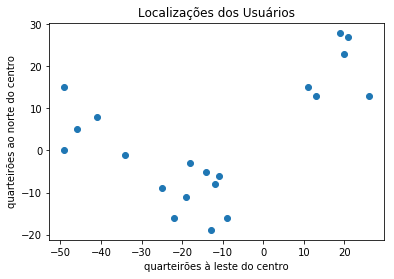

In [91]:
data = df.values
plt.scatter(data[:,0], data[:,1])
plt.title("Localizações dos Usuários")
plt.xlabel("quarteirões à leste do centro")
plt.ylabel("quarteirões ao norte do centro")
plt.show()

Dependendo de como você olha para o gráfico acima, você provavelmente verá dois ou três clusters. Isso é fácil de fazer visualmente porque os dados são apenas bidimensionais. Com mais dimensões, seria muito mais difícil de observar.

Imagine primeiro que você tem orçamento suficiente para três encontros. Você vai ao seu computador e tenta isto:

In [92]:
inputs = data.tolist()
random.seed(0) # so you get the same results as me
clusterer = KMeans(3)
clusterer.train(inputs)
print(clusterer.means)

[array([-25.85714286,  -4.71428571]), array([20., 26.]), array([16.66666667, 13.66666667])]


Vamos plotar o agrupamento e esses centroides:

In [93]:
def plotKmeans(data, kmeans_clusterer):
    colors = {0: "r", 1: "b", 2: "g", 3:"m"}
    markers = {0:"o", 1:"s", 2:"p", 3:"*"}
    assigns = np.array(kmeans_clusterer.assignments)
    for i in range(clusterer.k):
        idx = np.where(assigns == i)
        plt.scatter(data[idx,0], data[idx,1], color=colors[i], marker=markers[i])
        plt.annotate(str(i), kmeans_clusterer.means[i])
    plt.show()

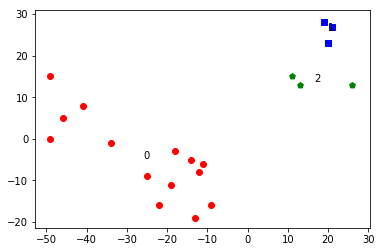

In [94]:
plotKmeans(data, clusterer)

Você encontra três grupos centralizados em `[-25.86,-4.71]`, `[20, 26]` e `[16.67, 13.67]` e você procura locais de encontro próximos a eles.

Você mostra para o diretor, que informa que agora só tem orçamento suficiente para dois encontros.

"Não tem problema", você diz:

[array([-25.85714286,  -4.71428571]), array([18.33333333, 19.83333333])]


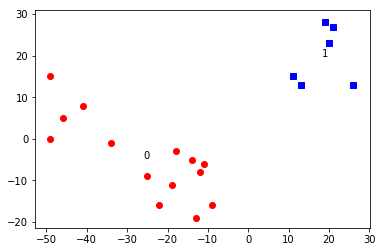

In [95]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
print(clusterer.means)
plotKmeans(data, clusterer)

Nesse caso, um ponto de encontro deve ser próximo a `[-25.86, -4.71]` e outro deve ser próximo a `[18.33, 19.83]`.

## Escolhendo k

No exemplo anterior, a escolha de $k$ foi motivada por fatores fora de nosso controle. Em geral, esse não será o caso. Existe uma grande variedade de maneiras de escolher um $k$. Uma que seja razoavelmente fácil de entender envolve a plotagem da soma dos erros quadrados (entre cada ponto e a média de seu cluster) como uma função de $k$ e a observação de onde o gráfico "dobra":

In [96]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    #assignments = list(map(clusterer.classify, inputs))
    assignments = clusterer.assignments

    return sum(distance.sqeuclidean(input,means[cluster])
               for input, cluster in zip(inputs, assignments))
    
    #return sum(squared_distance(input,means[cluster])
    #           for input, cluster in zip(inputs, assignments))


In [97]:
def plot_squared_clustering_errors(inputs):

    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.title("Total Error vs. # of Clusters")
    plt.show()

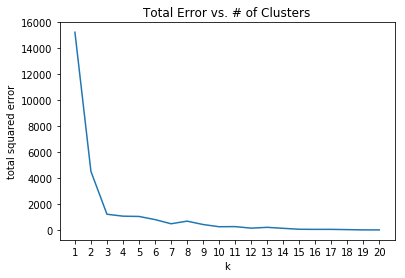

In [98]:
plot_squared_clustering_errors(inputs)

Olhando para o gráfico acima, este método concorda com a nossa visão original de que 3 é o número "certo" de clusters. Note que estamos usando como métrica de distância o quadrado da distância euclidiana. Se usarmos distância euclidiana padrão, o gráfico ficará diferente e a "dobra" mais difícil de perceber.

## Exemplo: agrupando cores

O diretor de marketing criou adesivos atraentes da DataSciencester que ele gostaria que você distribuísse em encontros. Infelizmente, sua impressora de adesivos pode imprimir no máximo cinco cores por adesivo. E como o diretor de Arte está em licença sabática, o diretor de marketing pergunta se há alguma maneira de você pegar o design dele e modificá-lo para que ele contenha apenas cinco cores.

Imagens de computador podem ser representadas como uma matriz bidimensional de pixels, onde cada pixel é um vetor tridimensional (vermelho, verde, azul) ([RGB](https://pt.wikipedia.org/wiki/RGB)) indicando sua cor.

Criar uma versão de cinco cores da imagem implica:

1. Escolher cinco cores
2. Atribuir uma dessas cores para cada pixel

Acontece que esta é uma ótima tarefa para o *k-means*, que pode particionar os pixels em cinco clusters no espaço vermelho-verde-azul. Se recolorirmos os pixels em cada cluster para a cor média, estamos prontos.

Para começar, precisamos de uma maneira de carregar uma imagem no Python. Acontece que podemos fazer isso com o `matplotlib`:

In [99]:
path_to_img_file = "./img/rainbow-birds-antony-galbraith.jpg"
img = mpimg.imread(path_to_img_file)

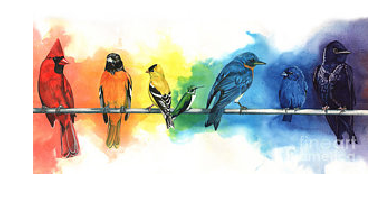

In [113]:
plt.imshow(img)
plt.axis('off')
plt.show()

Nos bastidores, `img` é um array NumPy, mas, para nossos propósitos, podemos tratá-la como uma lista de listas de listas.

`img[i][j]` é o pixel na i-ésima linha e j-coluna e cada pixel é uma lista `[vermelho, verde, azul]` de números entre `0` e `255`, indicando a cor desse pixel:

In [108]:
print("dimensões da imagem:", img.shape[0], "por", img.shape[1])
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel
print("cor do pixel mais à esquerda e acima:",red, green, blue)

dimensões da imagem: 147 por 300
cor do pixel mais à esquerda e acima: 255 255 255


Em particular, podemos obter uma lista simples contendo todos os pixels como:

In [109]:
pixels = [pixel for row in img for pixel in row]

E aí alimetar o nosso *clusterer* com essa lista:

In [110]:
clusterer = KMeans(5)
clusterer.train(pixels) # this might take a while

Assim que terminar, apenas construímos uma nova imagem com o mesmo formato:

In [114]:
def recolor(pixel):
    cluster = clusterer.classify(pixel) # index of the closest cluster
    return clusterer.means[cluster]     # mean of the closest cluster

new_img = [[recolor(pixel) for pixel in row] for row in img]

Depois, podemos mostrar a imagem usando `plt.imshow()`:

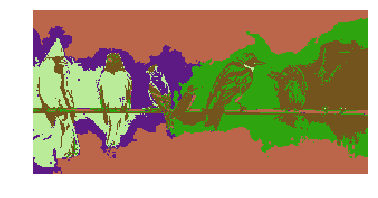

In [115]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

## Agrupamento hierárquico de baixo para cima

Uma abordagem alternativa de *clustering* é "aumentar" os clusters de baixo para cima. Podemos fazer isso da seguinte maneira:

1. Faça de cada entrada seu próprio cluster.
2. Enquanto houver múltiplos clusters restantes, encontre os dois clusters mais próximos e mescle-os.

No final, teremos um cluster gigante contendo todas as entradas. Se acompanharmos a ordem de mesclagem, podemos recriar qualquer número de clusters por meio de desmembramento. Por exemplo, se queremos três clusters, podemos apenas desfazer as duas últimas mesclagens.

Usaremos uma representação realmente simples de clusters. Nossos valores estarão nos clusters folhas, os quais representamos como 1-tuplas:

In [116]:
leaf1 = ([10, 20],) # to make a 1-tuple you need the trailing comma
leaf2 = ([30, -15],) # otherwise Python treats the parentheses as parentheses

Usamos isso para aumentar os clusters mesclados, que representamos como 2-tuplas (ordem de mesclagem, filhos):

In [117]:
merged = (1, [leaf1, leaf2])

Falaremos sobre a ordem de mesclagem em breve, mas primeiro vamos criar algumas funções auxiliares:

In [118]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]


Para mesclar os clusters mais próximos, precisamos de alguma noção da distância entre eles. Usaremos a *distância mínima* entre os elementos dos dois clusters, que mescla os dois clusters mais próximos do toque. Embora essa medida de distância faça sentido, às vezes produz grandes clusters semelhantes a cadeias que não são muito concisos. Se quiséssemos clusters esféricos concisos, poderíamos usar a *distância máxima*, uma vez que ela mescla os dois grupos que se encaixam na menor bola. Ambas são escolhas comuns, assim como a *distância média*:

In [119]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance.euclidean(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])


Usaremos o campo da tupla que marca a ordem de mesclagem para acompanhar a ordem em que fizemos a mesclagem. Números menores representarão fusões posteriores. Isso significa que, quando queremos separar clusters, fazemos isso da menor ordem de mesclagem para a mais alta. Como os agrupamentos de folhas nunca foram mesclados (o que significa que nunca queremos desmembrá-los), atribuiremos a eles *infinito*:

In [120]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

Agora estamos prontos para criar o algoritmo de *clustering*:

In [121]:
def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

O seu uso é muito simples:

In [122]:
base_cluster = bottom_up_cluster(inputs)

Isso produz uma representação muito feia:

In [137]:
print(base_cluster)

(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])


Ou, de forma um pouco mais amigável:

`(0, [(1, [(3, [(14, [(18, [([19, 28],),
                            ([21, 27],)]),
                      ([20, 23],)]),
                ([26, 13],)]),
           (16, [([11, 15],),
                 ([13, 13],)])]),
      (2, [(4, [(5, [(9, [(11, [([-49, 0],),
                                ([-46, 5],)]),
                          ([-41, 8],)]),
                     ([-49, 15],)]),
                ([-34, -1],)]),
           (6, [(7, [(8, [(10, [([-22, -16],),
                                ([-19, -11],)]),
                          ([-25, -9],)]),
                     (13, [(15, [(17, [([-11, -6],),
                                       ([-12, -8],)]),
                                 ([-14, -5],)]),
                           ([-18, -3],)])]),
                (12, [([-13, -19],),
                      ([-9, -16],)])])])])`

Para cada cluster mesclado, eu alinhei seus filhos verticalmente. Se dissermos "cluster 0" para o cluster com ordem de mesclagem 0, você poderá interpretar isso como:
* O cluster 0 é o resultado da fusão do cluster 1 e do cluster 2.
* O cluster 1 é o resultado da fusão do cluster 3 e do cluster 16.
* O cluster 16 é o resultado da fusão folha `[11, 15]` e a folha `[13, 13]`.
* E assim por diante…

Como tínhamos 20 entradas, foram necessárias 19 mesclagens para chegarmos a um único cluster. A primeira mesclagem criou o cluster 18 combinando as folhas `[19, 28]` e `[21, 27]`. E a última mesclagem criou o cluster 0.

Geralmente, no entanto, não queremos ficar de olho em representações desagradáveis de texto como essa. (Embora possa ser um exercício interessante criar uma visualização mais fácil para o usuário da hierarquia de clusters.) Em vez disso, vamos escrever uma função que gere qualquer número de clusters executando o número apropriado de *unmerges*:

In [138]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

Então, por exemplo, se queremos gerar três clusters, podemos apenas fazer:

In [145]:
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]
for i in range(3):
    print("cluster", i, ":", three_clusters[i])

cluster 0 : [[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
cluster 1 : [[19, 28], [21, 27], [20, 23], [26, 13]]
cluster 2 : [[11, 15], [13, 13]]


Que podemos plotar facilmente:

In [147]:
def plot_three_clusters_HC(three_clusters):
    for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters,
                                     ['D','o','*'],
                                     ['r','g','b']):
        xs, ys = zip(*cluster) # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)
        # put a number at the mean of the cluster
        x, y = np.mean(cluster, axis=0)
        #x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')

    plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
    plt.xlabel("blocks east of city center")
    plt.ylabel("blocks north of city center")
    plt.show()

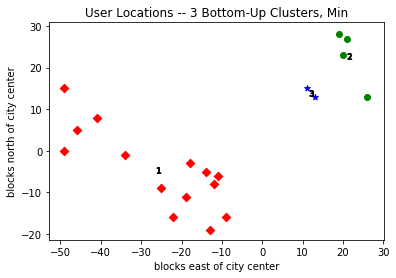

In [148]:
plot_three_clusters_HC(three_clusters)

Note que o resultado acima é um pouco diferente do resultado dado pelo *k-means*.

Como mencionamos acima, isso ocorre porque usar *min* em `cluster_distance` tende a gerar clusters de cadeia. Se ao invés disso usarmos `max` (o que gera clusters mais concisos), o resultado do agrupamento muda significativamente:

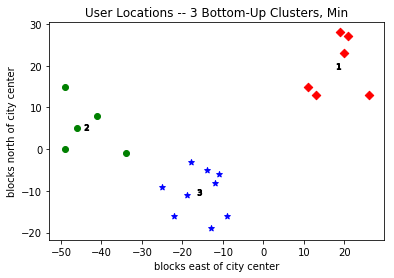

In [150]:
base_cluster = bottom_up_cluster(inputs, distance_agg=max)
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]
plot_three_clusters_HC(three_clusters)

A implementação `bottom_up_clustering` acima é relativamente
simples, mas também é chocantemente ineficiente. Em particular, recalcula a distância entre cada par de entradas em cada etapa. Uma implementação mais eficiente pode pré-calcular as distâncias entre cada par de entradas e, em seguida, executar uma pesquisa dentro de `cluster_distance`. Uma implementação realmente eficiente provavelmente também lembraria as `cluster_distances` da etapa anterior.

## Para explorar

* O [`scikit-learn`](http://scikit-learn.org/) tem um módulo inteiro [`sklearn.cluster`](http://scikit-learn.org/stable/modules/clustering.html) que contém vários algoritmos de clustering, incluindo o KMeans e o algoritmo de clustering hierárquico Ward (que usa um critério diferente para mesclar clusters do que o nosso).

* O [`SciPy`](https://www.scipy.org/) possui dois modelos de clustering [`scipy.cluster.vq`](https://docs.scipy.org/doc/scipy/reference/cluster.vq.html) (que faz *k-means*) e [`scipy.cluster.hierarchy`](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) (que possui uma variedade de algoritmos hierárquicos de *clustering*).